In [1]:
#!pip install yfinance
#!pip install hmmlearn
#pip install arch
#pip install scipy
#pip install --upgrade --user hmmlearn
#pip install --user git+https://github.com/hmmlearn/hmmlearn
from sklearn.mixture import GaussianMixture
import yfinance as yf
import numpy as np
from numpy import random
import pandas as pd
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score 
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2, t, norm
import datetime as dt
from datetime import datetime
from itertools import product
from arch import arch_model

# Data collection

In [2]:
ticker = "^GSPC"  #S&P 500 index symbol
daily = yf.download(ticker, start="1950-01-01", end="2024-11-30", interval="1d")
#daily.loc[(daily['Open'] == 0) & (daily.index >= '1961-12-29') & (daily.index <= '1982-04-20'), 'Open'] = np.nan
#Before 29th Dec 1961, same values in the row
#Between 29th Dec 1961 and 20th April 1982, "Open" set to 0

daily = daily[daily.columns[0:4]]

[*********************100%%**********************]  1 of 1 completed


c:\Users\graci\anaconda3\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [3]:
# Resample the data to monthly frequency
monthly = daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})
monthly = monthly.dropna()
monthly_with_dates = monthly

# Reset the index to have 'Date' as a column
monthly = monthly.reset_index()

#calculate log returns
log_returns = np.log(monthly_with_dates['Close'] / monthly_with_dates['Close'].shift(1)).dropna()


<Axes: >

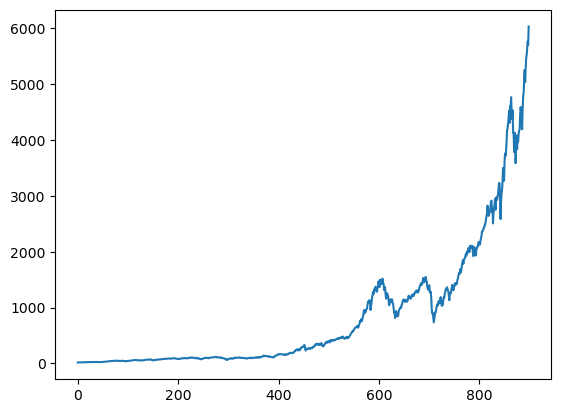

In [4]:
monthly['Close'].plot()

# ADF Test

We run a Dickey-Fuller test to test for the stationnarity of our time series. Our result shows that the time series is not stationary which means that the stastiscal properties are not constant over time. This non stationarity leads to several issues such as

In [5]:
True_price = monthly_with_dates['Close']
print(True_price.shape)

(899,)


In [6]:
True_price

Date
1950-01-01      17.049999
1950-02-01      17.219999
1950-03-01      17.290001
1950-04-01      17.959999
1950-05-01      18.780001
                 ...     
2024-07-01    5522.299805
2024-08-01    5648.399902
2024-09-01    5762.479980
2024-10-01    5705.450195
2024-11-01    6032.379883
Freq: MS, Name: Close, Length: 899, dtype: float64

In [7]:
sm.tsa.stattools.adfuller(True_price, regression='n', autolag='BIC', store=False, regresults=True)

(5.530603168749355,
 1.0,
 {'1%': -2.5682738268565344,
  '5%': -1.941308107020567,
  '10%': -1.616522983799078},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2817d0d3d70>)

In [8]:
sm.tsa.stattools.adfuller(True_price, regression='c', autolag='BIC', store=False, regresults=True)

(4.977697371218509,
 1.0,
 {'1%': -3.4377689935918783,
  '5%': -2.864815046188292,
  '10%': -2.5685138660653957},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2817d046750>)

In [ ]:
sm.tsa.stattools.adfuller(True_price, regression='ct', autolag='BIC', store=False, regresults=True)
#we cannot reject H0 which means that the TS is non-stationary

(3.531259545130856,
 1.0,
 {'1%': -3.969047635796577,
  '5%': -3.415468144550754,
  '10%': -3.1299799419503365},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2817d0bbc50>)

To overcome this issues, we transform the time series into a stationary one by differenciating each price by one lag. Now, when we run the ADF test, the null hypothesis is rejected i.e the time series is stationary.

In [10]:
True_price_diff = True_price.diff().dropna()  #we differenciate the TS to make it stationnary


In [11]:
sm.tsa.stattools.adfuller(True_price_diff, regression='n', autolag='BIC', store=False, regresults=True)
#now it is stationary

(-5.718159037552288,
 3.7035690751270905e-08,
 {'1%': -2.5682567137987626,
  '5%': -1.941306001663903,
  '10%': -1.6165249633898795},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2817d0bb440>)

In [12]:
sm.tsa.stattools.adfuller(True_price_diff, regression='c', autolag='BIC', store=False, regresults=True)

(-6.048662561267602,
 1.293361527372057e-07,
 {'1%': -3.43771883253448,
  '5%': -2.8647929301713977,
  '10%': -2.568502085595253},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2817ab669f0>)

In [13]:
sm.tsa.stattools.adfuller(True_price_diff, regression='ct', autolag='BIC', store=False, regresults=True)

(-6.667193399524685,
 7.882817558709957e-08,
 {'1%': -3.9689781021789607,
  '5%': -3.415434505721528,
  '10%': -3.1299601554678294},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2817d0d06b0>)

# Ljung box test

Now that we have a stationnary time series, we want to check for autocorrelation in the white noise. In other words, we want to see if the white have serial dependance. By looking at the result of the Ljung-Box test we see that indeed there is autocorelation in the white noise.

In [14]:
#===========================================================================
# Ljung-Box test to check whether my time series is a White Noise
#===========================================================================
#so there is autocorrelations in the residuals

n_autocor = 5
sm.stats.diagnostic.acorr_ljungbox(True_price_diff, lags=[n_autocor])

,lb_stat,lb_pvalue
5,25.889188,0.000094


# ARMA model

Now, we try to apply a ARMA process on the time series to account for the serial dependance in our series. 

In [16]:
#===========================================================================
# estimate ARMA 
#===========================================================================
ar_order = [0, 1, 2, 3, 4, 5]
d_order = [0]
ma_order = [0, 1, 2, 3, 4]
arma_res = [list(orders) for orders in product(ar_order, d_order, ma_order)]
#     pprint.pprint(arma_res)

# sm.tsa.arima.model.ARIMA
for order in arma_res:
    print('fitting: ar:{} -d:{} - ma:{}'.format(*order)) 
    try:
        arma_model = sm.tsa.arima.ARIMA(True_price_diff, order=order).fit()
        order.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        order.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'd_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 -d:0 - ma:0
fitting: ar:0 -d:0 - ma:1
fitting: ar:0 -d:0 - ma:2
fitting: ar:0 -d:0 - ma:3
fitting: ar:0 -d:0 - ma:4
fitting: ar:1 -d:0 - ma:0
fitting: ar:1 -d:0 - ma:1
fitting: ar:1 -d:0 - ma:2
fitting: ar:1 -d:0 - ma:3
fitting: ar:1 -d:0 - ma:4
fitting: ar:2 -d:0 - ma:0
fitting: ar:2 -d:0 - ma:1


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


fitting: ar:2 -d:0 - ma:2
fitting: ar:2 -d:0 - ma:3
fitting: ar:2 -d:0 - ma:4


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:3 -d:0 - ma:0
fitting: ar:3 -d:0 - ma:1
fitting: ar:3 -d:0 - ma:2


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


fitting: ar:3 -d:0 - ma:3


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


fitting: ar:3 -d:0 - ma:4


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:4 -d:0 - ma:0
fitting: ar:4 -d:0 - ma:1
fitting: ar:4 -d:0 - ma:2


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:4 -d:0 - ma:3


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:4 -d:0 - ma:4


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:5 -d:0 - ma:0
fitting: ar:5 -d:0 - ma:1
fitting: ar:5 -d:0 - ma:2
fitting: ar:5 -d:0 - ma:3


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:5 -d:0 - ma:4


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


criterion
     ar_order  d_order  ma_order        aic        bic
0          0        0         0  10.002979  10.012579
1          0        0         1   9.998455  10.012855
2          0        0         2  10.000230  10.019431
3          0        0         3   9.988172  10.012173
4          0        0         4   9.989449  10.018250
5          1        0         0   9.998863  10.013263
6          1        0         1  10.000396  10.019597
7          1        0         2   9.981856  10.005857
8          1        0         3   9.967564   9.996365
9          1        0         4   9.969468  10.003069
10         2        0         0   9.999075  10.018275
11         2        0         1   9.996041  10.020042
12         2        0         2   9.968600   9.997401
13         2        0         3   9.968384  10.001986
14         2        0         4   9.967232  10.005633
15         3        0         0   9.990926  10.014926
16         3        0         1   9.971609  10.000410
17         3     

By looking at the result, we see that the model that minimzes the BIC is a ARMA(3,4)

In [ ]:
res = sm.tsa.arima.ARIMA(True_price_diff, order=(3,0,4)).fit()
res
print(res.summary())
res.aic

c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  898
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -4957.381
Date:                Wed, 01 Jan 2025   AIC                           9932.763
Time:                        16:12:34   BIC                           9975.964
Sample:                    02-01-1950   HQIC                          9949.268
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7512     71.555      0.094      0.925    -133.495     146.997
ar.L1          0.9897      0.009    108.412      0.000       0.972       1.008
ar.L2         -0.9604      0.010    -97.766      0.0

9932.762966552897

# ARCH test

We then run a ARCH test on the squared residuals to check for homoskedacity. The goal here is to make sure that the ARMA model captured all the volatility. However by looking at the result, we see that the residuals are heteroskedastic. 

In [18]:
residus = res.resid

In [19]:
#===========================================================================
# ARCH tests 
#===========================================================================

n_autocor = 5
sm.stats.diagnostic.acorr_ljungbox(residus**2, lags=[n_autocor])
#We have heteroskedacity

,lb_stat,lb_pvalue
5,735.103968,1.259838e-156


# GARCH model

Because of that heteroskedacity, we are going to model a GARCH model to account for the volatility. 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6207.94484444074
Iteration:      2,   Func. Count:     12,   Neg. LLF: 6455.436482509011
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4011.848561598202
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3990.726819374558
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3979.1596378966797
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3940.6414822295033


Iteration:      7,   Func. Count:     40,   Neg. LLF: 4068.20913130059
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3912.276247406519
Iteration:      9,   Func. Count:     51,   Neg. LLF: 4968.098748938582
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4802.175849725851
Iteration:     11,   Func. Count:     65,   Neg. LLF: 3757.3012273486875
Iteration:     12,   Func. Count:     71,   Neg. LLF: 3683.1991030999598
Iteration:     13,   Func. Count:     76,   Neg. LLF: 3657.4669700063714
Iteration:     14,   Func. Count:     81,   Neg. LLF: 3649.6405529866847
Iteration:     15,   Func. Count:     86,   Neg. LLF: 3618.767186547937
Iteration:     16,   Func. Count:     91,   Neg. LLF: 3611.24547699794
Iteration:     17,   Func. Count:     96,   Neg. LLF: 22644.017692616195
Iteration:     18,   Func. Count:    103,   Neg. LLF: 3687.5694343193904
Iteration:     19,   Func. Count:    109,   Neg. LLF: 3600.2267661509914
Iteration:     20,   Func. Count:    114,   Neg. LLF: 3597.

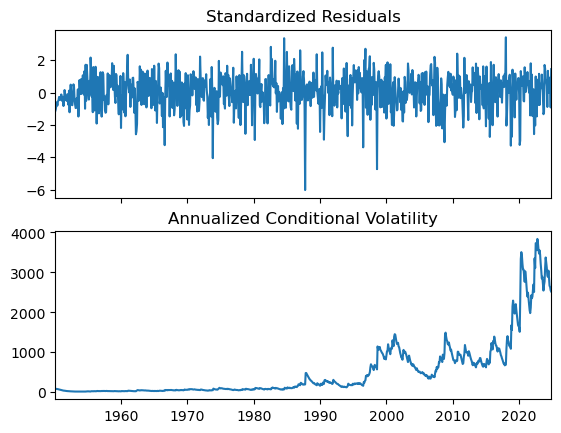

In [20]:
garch_res = arch_model(residus, p=1, o=0, q=1, dist='normal').fit()
print(garch_res.summary())
fig = garch_res.plot(annualize='D')

# Forecast

Now, we are trying to model a HMM-GARCH model to forecast our time series. Indeed, here the goal is to predict stock returns while capturing the volatility. Here, we use stock return to have stationarity in our time series. 

In [21]:
# Fit HMM with 6 regimes
log_returns = log_returns.values.reshape(-1, 1)

hmm_model = GaussianHMM(n_components=6, covariance_type="diag", init_params="c")
hmm_model.fit(log_returns)

hidden_states = hmm_model.decode(log_returns)[1]

c:\Users\graci\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\graci\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\graci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


When applying a GARCH(1,1) to each of the hidden states, we see that for most of the states the volatility comes from past volatility. This persistance of volatility make our addition of a GARCH component less useful because here the volatility is not due to new shock but past values. For that reason, HMM-GARCH model would be a overkill and not improve the overall performance. 

In [22]:
# Rescale the data
log_returns_rescaled = log_returns * 100

regimes = {}
garch_models = {}

# Loop through each hidden state (regime)
for i in range(hmm_model.n_components):  # Replace `hmm.n_components` with `hmm_model.n_components` if needed
    # Extract regime data
    regimes[i] = log_returns_rescaled[hidden_states == i]
    
    if len(regimes[i]) > 0:  # Check if the regime has data
        print(f"Fitting GARCH(1,1) for Regime {i}...")
        garch_models[i] = arch_model(regimes[i], vol='Garch', p=1, q=1).fit(disp="off")
        print(f"\nRegime {i} GARCH Summary:")
        print(garch_models[i].summary())
    else:
        print(f"\nRegime {i} has no data.")

Fitting GARCH(1,1) for Regime 0...

Regime 0 GARCH Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1847.38
Distribution:                  Normal   AIC:                           3702.75
Method:            Maximum Likelihood   BIC:                           3721.06
                                        No. Observations:                  719
Date:                Wed, Jan 01 2025   Df Residuals:                      718
Time:                        16:12:41   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu        